In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

### Extract `numerical` and `categorical` data from original dataframe

In [10]:
def load_original_data():
    df = pd.read_csv(r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\IH_RH_DA_FT_AUG_2022\Class_Materials\Case_Studies\Customer_Analysis_Case_Study\Data\Data_Marketing_Customer_Analysis_Round3.csv")        
    return df

def get_numerical(df):
    df_numerical = df.select_dtypes(exclude=['object'])
    # Drop number of open complaints as this is technically categorical data
    df_numerical.drop("number_of_open_complaints", axis=1, inplace=True)
    return df_numerical

def get_categorical(df):
    df_categorical = df.select_dtypes(include=['object'])
    return df_categorical

def transform_categorical(df):
    df_categorical = get_categorical(df)
    # Drop effective to date column
    df_categorical.drop("effective_to_date", axis=1, inplace=True) 
    
    df = load_original_data()
    # Insert number of open complaints as this is technically categorical data
    df_categorical.insert(len(df_categorical.columns)-1, "number_of_open_complaints", df["number_of_open_complaints"])
    
    # Convert policy to numbers for ordinal later
    policy_dict = {"personal l1": 1, "personal l2": 2, "personal l3": 3,
                    'corporate l1': 4, 'corporate l2': 5, 'corporate l3': 6,
                    'special l1': 7, 'special l2': 8, 'special l3': 9}
    policies = [policy_dict[policy] for policy in df_categorical["policy"]]
    df_categorical["policy"] = policies
    
    # Convert education  to numbers for ordinal later
    education_dict = {'high school or below': 0,
                      'bachelor': 1,
                      'master': 2,
                      'college': 2,
                      'doctor': 3}
    educations = [education_dict[edu] for edu in df_categorical["education"]]
    df_categorical["education"] = educations
    
    return df_categorical

df = load_original_data()
df_numerical = get_numerical(df)
df_categorical = transform_categorical(df)

In [13]:
df_categorical_ordinal = df_categorical[["education", "policy", "number_of_open_complaints"]]
df_categorical_nominal = df_categorical.drop(columns=["education", "policy", "number_of_open_complaints"])

### Create `correlation heatmap` to show interaction of every feature with every other feature

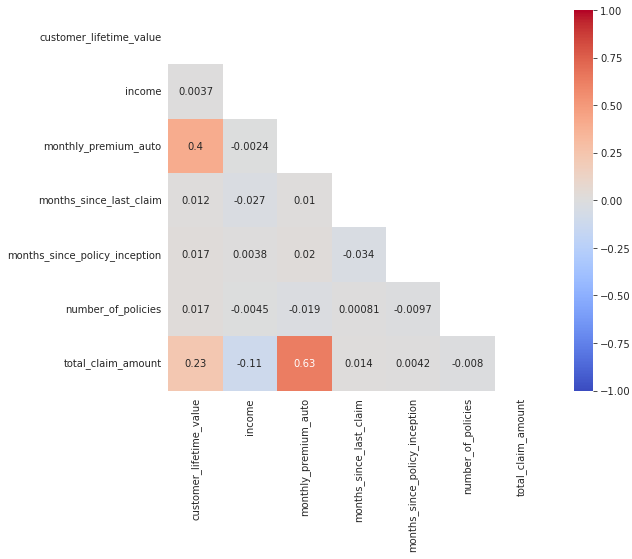

In [6]:
corr_matrix = df_numerical.corr()
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

### Check if there are highly correlated features and drop them if there are any

In [7]:
def show_corr_higher_threshold(df, threshold):
    """
    Show any features that have correlation higher than threshold with any other;
    """
    corr_matrix=df.corr().abs()
    upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    
    return [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

show_corr_higher_threshold(df_numerical, 0.8)

[]

`There are no highly correlated (> 0.8) features, so none will be dropped!`

### One Hot/Label Encoding of the categorical variables

In [8]:
df_categorical_hotcoded = pd.get_dummies(df_categorical, drop_first=True) # 43 columns
df_categorical_hotcoded_ = pd.get_dummies(df_categorical, drop_first=False) # 58 columns

### X-y Split (`y` is the target variable, which is the `total claim amount`)

In [48]:
X = df_numerical.drop('total_claim_amount', axis=1)
y = df_numerical["total_claim_amount"]

### Train - Test - Split

In [53]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.2,random_state=6969)

### Standardize the data after data split

In [54]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((8551, 6), (2138, 6))